# Creating training masks with the solaris python API <a href="https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_masks_tutorial.html">[1]</a>


You can create training masks from geojson-formatted labels with a single solaris command. Here, we’ll go through creating masks using a sample image and geojson provided with solaris

Solaris enables creation of four types of masks:

    Polygon footprints, for buildings or other objects

    Polygon outlines, for outlines of buildings or other target objects

    Polygon contact points, for places where polygons are closely apposed to one another (e.g. buildings in suburbs)

    Road network masks, from linestring-formatted road networks

The first three options here can also be combined to make multi-channel training targets, as many of the SpaceNet 4 competitors did.

Let’s start with creating building footprints.


## Polygon footprints
The solaris.vector.mask.footprint_mask() function creates footprints from polygons, with 0s on the outside of the polygon and burn_value on the inside. 


Let’s make a mask! We’ll use sample_geotiff.tif from the sample data and geotiff_labels.geojson for polygons. First, we’ll open those two objects up so you can see what we’re working with.

In [1]:
import solaris as sol
from solaris.data import data_dir
import os
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union

/home/sebasmos/anaconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sebasmos/anaconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sebasmos/anaconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sebasmos/anaconda3/envs/solaris

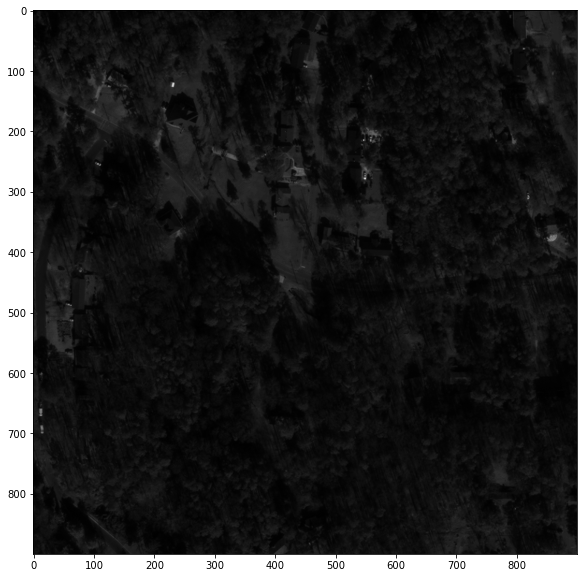

In [2]:
image = skimage.io.imread(os.path.join(data_dir, 'sample_geotiff.tif'))
f, axarr = plt.subplots(figsize=(10, 10))
plt.imshow(image, cmap='gray')

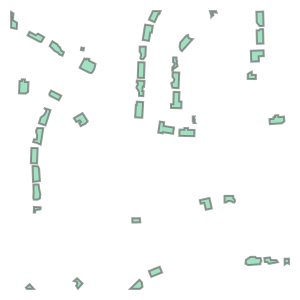

In [3]:
gdf = gpd.read_file(os.path.join(data_dir, 'geotiff_labels.geojson'))
cascaded_union(gdf.geometry.values)

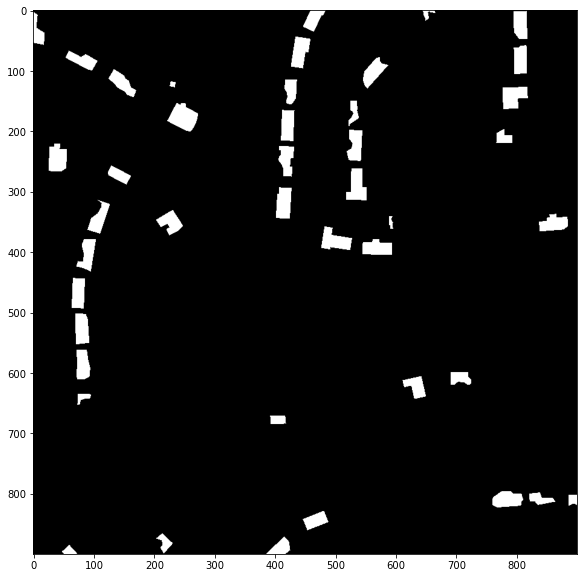

In [4]:
fp_mask = sol.vector.mask.footprint_mask(df=os.path.join(data_dir, 'geotiff_labels.geojson'),
                                      reference_im=os.path.join(data_dir, 'sample_geotiff.tif'))
f, ax = plt.subplots(figsize=(10, 10))
plt.imshow(fp_mask, cmap='gray')

## Polygon outlines

What if we want to find all of the edges of these buildings? In that case, we can use the `solaris.vector.mask.boundary_mask()` function. There are a few arguments to this function:

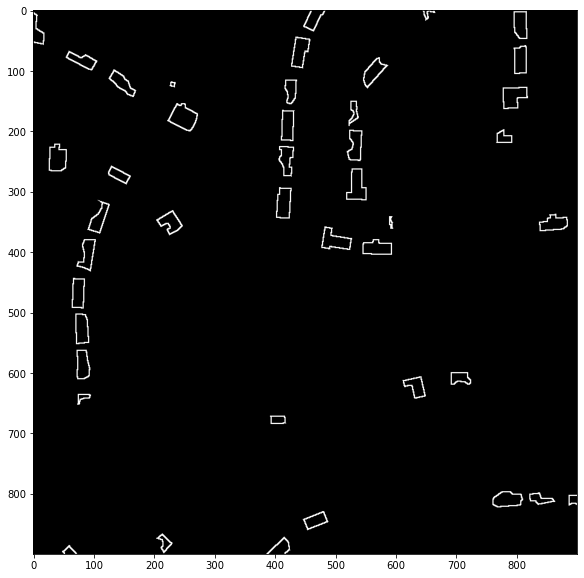

In [5]:
b_mask = sol.vector.mask.boundary_mask(fp_mask, boundary_width=5)
f, ax = plt.subplots(figsize=(10, 10))
ax.imshow(b_mask, cmap='gray')

## Polygon contact points

What about training a model to specifically find places where buildings are near each other? This can be helpful for the same purpose as the edges. The `solaris.vector.mask.contact_mask()` function creates this

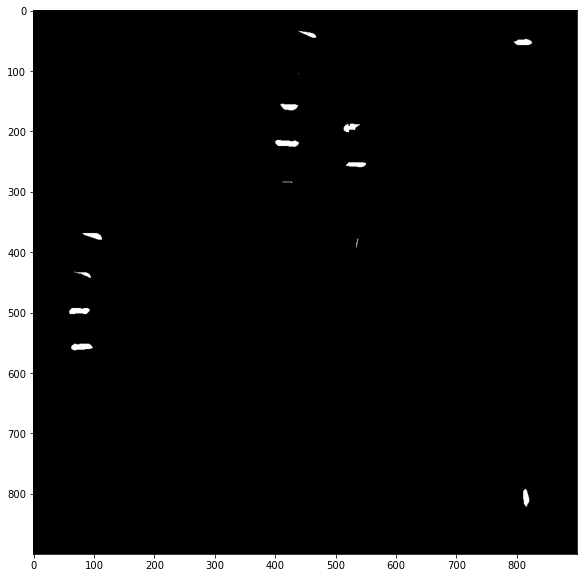

In [6]:
c_mask = sol.vector.mask.contact_mask(df=os.path.join(data_dir, 'geotiff_labels.geojson'),
                                      reference_im=os.path.join(data_dir, 'sample_geotiff.tif'),
                                      contact_spacing=10, meters=True)
f, ax = plt.subplots(figsize=(10, 10))
ax.imshow(c_mask, cmap='gray')

Finally, let’s create a three-channel mask containing all three of these layers! The `solaris.vector.mask.df_to_px_mask()` function takes all of the same arguments as above, plus channels, a list specifying which of the three types of masks should be included. We’ll make one that has them all!

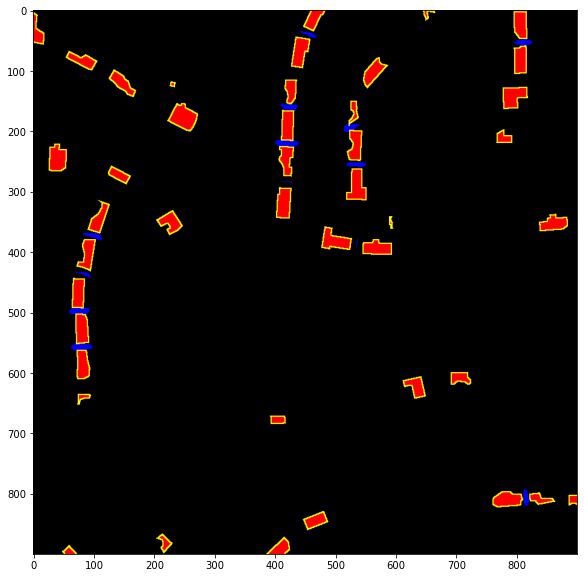

In [7]:
fbc_mask = sol.vector.mask.df_to_px_mask(df=os.path.join(data_dir, 'geotiff_labels.geojson'),
                                         channels=['footprint', 'boundary', 'contact'],
                                         reference_im=os.path.join(data_dir, 'sample_geotiff.tif'),
                                         boundary_width=5, contact_spacing=10, meters=True)
f, ax = plt.subplots(figsize=(10, 10))
ax.imshow(fbc_mask)

We will use this mask for training models

## Road network masks

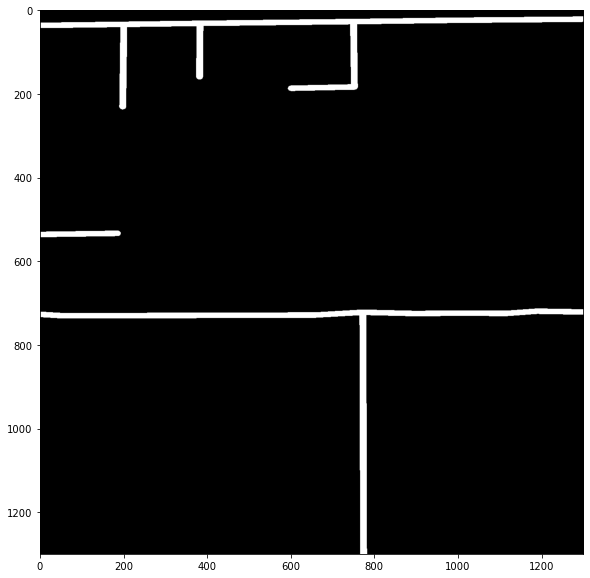

In [8]:
road_mask = sol.vector.mask.road_mask(os.path.join(data_dir, 'sample_roads_for_masking.geojson'),
                                      reference_im=os.path.join(data_dir, 'road_mask_input.tif'),
                                      width=4, meters=True)

f, ax = plt.subplots(figsize=(10, 10))
ax.imshow(road_mask, cmap='gray')